In [2]:
### Note: The full results are shown in test_results.ipynb

In [1]:
import pandas as pd
import numpy as np

from collections import Counter
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import copy

import time

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from transformers.optimization import AdamW
from transformers import AutoTokenizer, AutoModel

In [3]:
import torch.optim as optim

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
import pickle

In [5]:
#Check if CUDA is available
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [6]:
dtrain = pd.read_csv('project_dtrain_clean.csv', index_col = 0)
dval = pd.read_csv('project_dval_clean.csv', index_col = 0)
dtest = pd.read_csv('project_dtest_clean.csv', index_col = 0)

In [63]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_Discharge_Summary_BERT")


In [64]:
#Preprocess data using BERT CLINIC tokenizer
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
def bert_load(data):
    '''
    Load in data
    Return BERT's preprocessed inputs including token_id, mask, label
    '''
    token_ids = []
    attention_masks = []
    for row in data['TEXT']:
        #row = re.sub('[\\(\[#.!?,\'\/\])0-9]', ' ', row)
        encoded_dict = tokenizer.encode_plus(row,
                                            add_special_tokens= True, #add [CLS], [SEP]
                                            max_length = 512,  
                                            pad_to_max_length = True, #pad and truncate
                                            return_attention_mask = True, #construct attention mask
                                            return_tensors = 'pt') #return pytorch tensor
        
        token_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    token_ids = torch.cat(token_ids,dim=0)
    attention_masks = torch.cat(attention_masks,dim=0)
    labels = torch.tensor(data['READMIT'].values)
    data_out = TensorDataset(token_ids, attention_masks, labels)
    return data_out
        
datatrain = bert_load(dtrain)   
dataval = bert_load(dval)
datatest = bert_load(dtest)

In [65]:
BATCH_SIZE = 12
train_loaderB = DataLoader(datatrain,
                           batch_size=BATCH_SIZE,
                           shuffle=True)
                           

val_loaderB = DataLoader(dataval,
                         batch_size=BATCH_SIZE,
                         shuffle= True)
                         

test_loaderB = DataLoader(datatest,
                         batch_size=BATCH_SIZE,
                         shuffle= False)

In [66]:
class BertClassification(nn.Module):
  
    def __init__(self):
        super(BertClassification, self).__init__()
        #self.num_labels = num_labels
        self.bert = AutoModel.from_pretrained("emilyalsentzer/Bio_Discharge_Summary_BERT")
        for param in self.bert.parameters():
            param.requires_grad = False
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 2)
        
        nn.init.xavier_normal_(self.classifier.weight)
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output = self.bert(input_ids,  attention_mask=attention_mask)
        pooled_output = self.dropout(pooled_output)
        outputs = self.classifier(pooled_output)
        #outputs = F.sigmoid(outputs)
        return outputs
    

#Since we are doing sentence-level classification, we can use the embeddings of the first token 
#in every batch i.e. ‘[CLS]’ and feed these embeddings to the fully connected layer which outputs 
#the logits (or scores) for the positive class. Note that, here using the embeddings of ‘[CLS]’ is a 
#sort of pooling over the whole sequence, you can perform average or max-pooling over the whole sequence 
#instead and it should also perform well enough.

#Note: https://huggingface.co/transformers/_modules/transformers/modeling_bert.html#BertForSequenceClassification

In [68]:
#del modelBERT
#torch.cuda.empty_cache()
modelBERT = BertClassification()
modelBERT.to(device)

BertClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

# EVALUATION

## BERT DISCHARGE

In [78]:
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

#TEST SET
torch.manual_seed(2020)

def evaluate_model(model):
    loss_fn = nn.CrossEntropyLoss()
    model.eval()
    total =0.
    correct = 0.
    y_pred =[]
    y_true= []
    y_proba = []
  
    with torch.no_grad():        
        for i, (data, mask, labels) in enumerate(test_loaderB):
            data, mask, labels = data.to(device), mask.to(device), labels.to(device,dtype=torch.long)

            model.zero_grad()

            outputs = model(data, token_type_ids = None,
                                          attention_mask= mask,
                                          labels =None)
            loss = loss_fn(outputs.view(-1,2), labels.view(-1))

            label_cpu = labels.squeeze().to('cpu').numpy()
            
            #predict probability
          
            proba = F.softmax(outputs).to('cpu').numpy()[:,1]
            
            #predict label
            pred = outputs.data.max(-1)[1].to('cpu').numpy()
        
            total += labels.size(0)
            correct += float(sum((pred ==label_cpu)))
            
           
            y_proba += list(proba)  #use for ROC and AUC
            y_pred += list(pred)    #use for confusion matrix
            y_true += list(label_cpu) #use for all
        
       
        v_auc = roc_auc_score(y_true, y_proba)
        v_acc = correct/total


    print('Test set | Accuracy: {:6.4f}'.format(v_acc))
    print('Test set | AUC: {:6.4f}'.format(v_auc))

    return y_true, y_pred, y_proba #y_proba_class0


In [21]:
#BERT CLINIC - fully train - lr = 2e-5, batch size = 6
model = torch.load('bert_clinic_base.pth')
model.to(device)
y_true, y_pred, y_proba = evaluate_model(model)

pickle.dump(y_pred,open("bert_clinic_base_ypred.pkl","wb"))
pickle.dump(y_proba,open("bert_clinic_base_yproba.pkl","wb"))

Test set | Accuracy: 0.7402
Test set | AUC: 0.7476


In [43]:
#bert_clinic_base2e5.pth  - lr = 2e-5, batch size = 12
model = torch.load('bert_clinic_base2e5.pth')  
model.to(device)
y_true, y_pred, y_proba = evaluate_model(model)

pickle.dump(y_pred,open("bert_clinic_base2e5_ypred.pkl","wb"))
pickle.dump(y_proba,open("bert_clinic_base2e5_yproba.pkl","wb"))

Test set | Accuracy: 0.7820
Test set | AUC: 0.7301


In [31]:
#bert_clinic_base3.pth  - lr = 3e-5, batch size = 12
model = torch.load('bert_clinic_base3.pth')  
model.to(device)
y_true, y_pred, y_proba = evaluate_model(model)

pickle.dump(y_pred,open("bert_clinic_base3_ypred.pkl","wb"))
pickle.dump(y_proba,open("bert_clinic_base3_yproba.pkl","wb"))

Test set | Accuracy: 0.7945
Test set | AUC: 0.7537


In [52]:
#bert_clinic_base3e5.pth  - lr = 3e-5, batch size = 6
model = torch.load('bert_clinic_base3e5.pth')  
model.to(device)
y_true, y_pred, y_proba = evaluate_model(model)

pickle.dump(y_pred,open("bert_clinic_base3e5_ypred.pkl","wb"))
pickle.dump(y_proba,open("bert_clinic_base3e5_yproba.pkl","wb"))

Test set | Accuracy: 0.7874
Test set | AUC: 0.7325


In [34]:
#bert_clinic_base2.pth  - lr = 5e-5, batch size = 12
model = torch.load('bert_clinic_base2.pth')  
model.to(device)
y_true, y_pred, y_proba = evaluate_model(model)

pickle.dump(y_pred,open("bert_clinic_base2_ypred.pkl","wb"))
pickle.dump(y_proba,open("bert_clinic_base2_yproba.pkl","wb"))

Test set | Accuracy: 0.7945
Test set | AUC: 0.7537


In [80]:
model = torch.load('bert_clinic_fc_2e5.pth')  
model.to(device)
y_true, y_pred, y_proba = evaluate_model(model)

pickle.dump(y_pred,open("model_clinic_fc2e5_ypred.pkl","wb"))
pickle.dump(y_proba,open("model_clinic_fc2e5_yproba.pkl","wb"))

Test set | Accuracy: 0.7766
Test set | AUC: 0.4733


In [86]:
#bert_clinic_base2.pth  - lr = 5e-5, batch size = 12
model = torch.load('bert_clinic_fc_2e2.pth')  
model.to(device)
y_true, y_pred, y_proba = evaluate_model(model)

pickle.dump(y_pred,open("bert_clinic_fc_2e2_ypred.pkl","wb"))
pickle.dump(y_proba,open("bert_clinic_fc_2e2_yproba.pkl","wb"))

Test set | Accuracy: 0.6464
Test set | AUC: 0.6803


## BERT BASE

In [55]:
#Preprocess data using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
def bert_load(data):
    '''
    Load in data
    Return BERT's preprocessed inputs including token_id, mask, label
    '''
    token_ids = []
    attention_masks = []
    for row in data['TEXT']:
        row = re.sub('[\\(\[#.!?,\'\/\])0-9]', ' ', row)
        encoded_dict = tokenizer.encode_plus(row,
                                            add_special_tokens= True, #add [CLS], [SEP]
                                            max_length = 512,  
                                            pad_to_max_length = True, #pad and truncate
                                            return_attention_mask = True, #construct attention mask
                                            return_tensors = 'pt') #return pytorch tensor
        
        token_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    token_ids = torch.cat(token_ids,dim=0)
    attention_masks = torch.cat(attention_masks,dim=0)
    labels = torch.tensor(data['READMIT'].values)
    data_out = TensorDataset(token_ids, attention_masks, labels)
    return data_out
        
#datatrain = bert_load(dtrain)   
#dataval = bert_load(dval)
datatest = bert_load(dtest)

In [56]:
BATCH_SIZE = 12
train_loaderB = DataLoader(datatrain,
                           batch_size=BATCH_SIZE,
                           shuffle=True)
                           

val_loaderB = DataLoader(dataval,
                         batch_size=BATCH_SIZE,
                         shuffle= True)
                         

test_loaderB = DataLoader(datatest,
                         batch_size=BATCH_SIZE,
                         shuffle= False)

In [57]:
torch.manual_seed(2020)

def evaluate_model(model):
    model.eval()
    total =0.
    correct = 0.
    y_pred =[]
    y_true= []
    y_proba = []
  
    with torch.no_grad():        
        for i, (data, mask, labels) in enumerate(test_loaderB):
            data, mask, labels = data.to(device), mask.to(device), labels.to(device)

            model.zero_grad()

            _, outputs = model(data, token_type_ids = None,
                                          attention_mask= mask,
                                          labels =labels)

            label_cpu = labels.squeeze().to('cpu').numpy()
            
            #predict probability
          
            proba = F.softmax(outputs).to('cpu').numpy()[:,1]
            
            #predict label
            pred = outputs.data.max(-1)[1].to('cpu').numpy()
        
            total += labels.size(0)
            correct += float(sum((pred ==label_cpu)))
            
           
            y_proba += list(proba)  #use for ROC and AUC
            y_pred += list(pred)    #use for confusion matrix
            y_true += list(label_cpu) #use for all
        
       
        v_auc = roc_auc_score(y_true, y_proba)
        v_acc = correct/total


    print('Test set | Accuracy: {:6.4f}'.format(v_acc))
    print('Test set | AUC: {:6.4f}'.format(v_auc))

    return y_true, y_pred, y_proba

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)
    #print(cm.shape)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(-0.5, cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return None


classes = ['no readmission','readmission']

In [58]:
model = torch.load('model_bert_pretrained.pth')  
model.to(device)
y_true, y_pred, y_proba = evaluate_model(model)

pickle.dump(y_pred,open("model_bert_pretrained_ypred.pkl","wb"))
pickle.dump(y_proba,open("model_bert_pretrained_yproba.pkl","wb"))

Test set | Accuracy: 0.7777
Test set | AUC: 0.6385


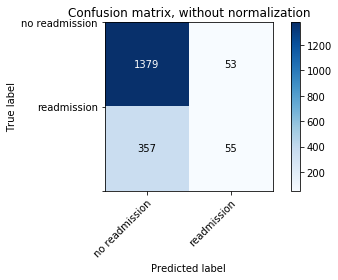

In [59]:
plot_confusion_matrix(y_true, y_pred, classes)

Test set | Accuracy: 0.7798
Test set | AUC: 0.6476


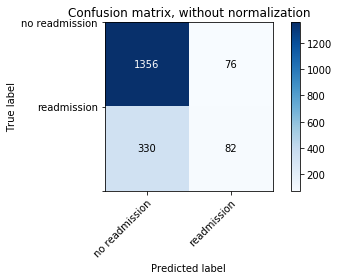

In [62]:
model = torch.load('model_bert_pretrained_fc.pth')  
model.to(device)
y_true, y_pred, y_proba = evaluate_model(model)

pickle.dump(y_pred,open("model_bert_pretrained_fc__ypred.pkl","wb"))
pickle.dump(y_proba,open("model_bert_pretrained_fc_yproba.pkl","wb"))

plot_confusion_matrix(y_true, y_pred, classes)